<a href="https://colab.research.google.com/github/mkatouda/qmlsample/blob/master/qiskit_qcl_regression_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Qiskitによる量子回路学習のサンプルコード: 関数の回帰問題**
量子機械学習にパラメータ化された量子回路(PQC)を適用しNISQ量子コンピュータで実行可能としたことでブレークスルーとなった手法として，大阪大学の御手洗らにより開発された量子回路学習(Quantum Cirquit Learning: QCL)が挙げられる．
本ノートブックでは，量子回路学習アルゴリズムをIBMの量子コンピューティングSDKであるQiskitを用いて実装した例を紹介する．量子回路学習アルゴリズムでは以下の手順で量子・古典ハイブリッド計算が行われる．2-4のプロセスは量子コンピュータで，1，5-6のプロセスは古典コンピュータでそれぞれ計算される．

1.   学習データ{(xi, yi), xiは入力データのベクトル, yiは出力データの真の値(教師データ)}を用意する．
2.   入力xを量子状態に埋め込む量子回路U_in(x) (特徴量マップとよぶ)を設定し，xiのデータを入力量子状態|ψ_in(xi)>=U_in(xi)|0>として埋め込む．
3.   変分最適化により調整可能なパラメータを持つ量子回路U_out(θ)を設定し，入力量子状態に作用させ，出力量子業態|ψ_out(xi, θ)>= U_out(θ)|ψ_in(xi)>を得る．
4.   出力量子状態に対し観測量の演算子を設定し，その観測量の測定値y(xi,θ)を得る．
5.   真の値yiと測定値y(xi,θ)間の乖離を表すコスト関数L(θ)を設定し，その値を極小化する方向に向かうθの候補値に更新する．
6.   3-5のプロセスを繰り返し，コスト関数L(θ)を最小化するパラメータθminを探索する．探索により得られたパラメータθminを用いたy(xi,θmin)を予測モデルとして採用する．


qiskitのインストール

In [335]:
!pip install qiskit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


必要なモジュールをインポート

In [336]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, transpile
from qiskit.algorithms.optimizers import COBYLA

QCLモデルの入力パラメータの設定


In [337]:
########  パラメータ  #############
# 乱数のシード
random_seed = 0
# 乱数発生器の初期化
np.random.seed(random_seed)

# Qubit数，回路の深さ，期待値の増幅係数
nqubit = 2
c_depth = 5
Mfac = 2.0

# 量子シミュレータの設定
num_shots = 8192

# パラメータオプティマイザの設定
maxiter = 100
tol = 0.05

回帰するデータの設定

In [338]:
########  学習データ  #############
# 回帰する関数の定義
#func_to_learn = lambda x: x**3
func_to_learn = lambda x: np.sin(x*np.pi)

# 回帰データの設定
x_min = -1.; x_max = 1.; num_x_train = 100
x_train = x_min + (x_max - x_min) * np.random.rand(num_x_train)
y_train = func_to_learn(x_train)

x_pred = np.arange(x_min, x_max, 0.02)
y_pred = func_to_learn(x_pred)

# 関数に正規分布ノイズを付加
mag_noise = 0.05
y_train += mag_noise * np.random.randn(num_x_train)

回帰データの可視化

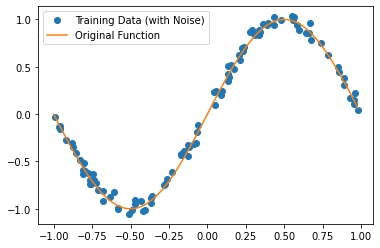

In [339]:
fig = plt.figure()
plt.plot(x_train, y_train, "o", label='Training Data (with Noise)')
plt.plot(x_pred, y_pred, label='Original Function')
plt.legend()
plt.show()
#plt.savefig('./inputdata-plot.png')

入力回路U_in(x)の設定


In [340]:
def U_in(x, nqubit):
    qr = QuantumRegister(nqubit)
    U = QuantumCircuit(qr)

    for j in range(2):
        for i in range(nqubit):
            U.ry(x, i)
            U.rz(x, i)
        for i in range(nqubit-1):
            U.cz(i, i+1)
        if nqubit >=3: U.cz(nqubit-1, 0)

    U.name = "U_in"
    return U

U_in(x_train[0], nqubit).draw()

┌──────────────┐┌──────────────┐   ┌──────────────┐┌──────────────┐»
q1361458_0: ┤ Ry(0.097627) ├┤ Rz(0.097627) ├─■─┤ Ry(0.097627) ├┤ Rz(0.097627) ├»
            ├──────────────┤├──────────────┤ │ ├──────────────┤├──────────────┤»
q1361458_1: ┤ Ry(0.097627) ├┤ Rz(0.097627) ├─■─┤ Ry(0.097627) ├┤ Rz(0.097627) ├»
            └──────────────┘└──────────────┘   └──────────────┘└──────────────┘»
«               
«q1361458_0: ─■─
«             │ 
«q1361458_1: ─■─
«

出力回路U_out(θ)の設定

In [341]:
def U_out(nqubit, c_depth, params):
    qr = QuantumRegister(nqubit)
    U = QuantumCircuit(qr)

    for d in range(c_depth):
        for i in range(nqubit-1):
            U.cz(i, i+1)
        if nqubit >=3: U.cz(nqubit-1, 0)
        for i in range(nqubit):
            U.rx(params[nqubit*3*d+3*i], i)
            U.rz(params[nqubit*3*d+3*i+1], i)
            U.rx(params[nqubit*3*d+3*i+2], i)

    U.name = "U_out"
    return U

出力回路U_out(θ)の回路パラメータθの初期化

In [342]:
num_vars = 3 * nqubit * c_depth
params = np.random.rand(num_vars) * 2 * np.pi
print('initial params', params)
U_out(nqubit, c_depth, params).draw()

initial params [1.30357293 2.6683775  2.35097932 2.9127303  1.74439261 3.68687478
 5.42776485 0.73847443 3.2507888  0.82980839 4.50416222 2.48851651
 3.55264688 1.15158117 0.91010531 3.06654805 2.23438073 5.90890818
 4.80868039 4.70399226 5.67823859 0.52415862 3.46952761 3.67237145
 6.04402452 1.83561705 1.51317185 0.63016542 0.10323041 5.84040495]


┌────────────┐┌────────────┐┌───────────┐     ┌────────────┐»
q1361459_0: ─■─┤ Rx(1.3036) ├┤ Rz(2.6684) ├┤ Rx(2.351) ├──■──┤ Rx(5.4278) ├»
             │ ├────────────┤├────────────┤├───────────┴┐ │ ┌┴────────────┤»
q1361459_1: ─■─┤ Rx(2.9127) ├┤ Rz(1.7444) ├┤ Rx(3.6869) ├─■─┤ Rx(0.82981) ├»
               └────────────┘└────────────┘└────────────┘   └─────────────┘»
«            ┌─────────────┐┌────────────┐   ┌────────────┐┌────────────┐»
«q1361459_0: ┤ Rz(0.73847) ├┤ Rx(3.2508) ├─■─┤ Rx(3.5526) ├┤ Rz(1.1516) ├»
«            └┬────────────┤├────────────┤ │ ├────────────┤├────────────┤»
«q1361459_1: ─┤ Rz(4.5042) ├┤ Rx(2.4885) ├─■─┤ Rx(3.0665) ├┤ Rz(2.2344) ├»
«             └────────────┘└────────────┘   └────────────┘└────────────┘»
«            ┌─────────────┐    ┌────────────┐┌───────────┐ ┌────────────┐   »
«q1361459_0: ┤ Rx(0.91011) ├─■──┤ Rx(4.8087) ├┤ Rz(4.704) ├─┤ Rx(5.6782) ├─■─»
«            └┬────────────┤ │ ┌┴────────────┤├───────────┴┐├────────────┤ │ »
«q1361459_1: ─┤ Rx(5.9089) ├─■─┤ Rx(0.52416) ├┤ Rz(3.4695) ├┤ Rx(3.6724) ├─■─»
«             └────────────┘   └─────────────┘└────────────┘└────────────┘   »
«             ┌───────────┐  ┌────────────┐┌────────────┐
«q1361459_0: ─┤ Rx(6.044) ├──┤ Rz(1.8356) ├┤ Rx(1.5132) ├
«            ┌┴───────────┴┐┌┴────────────┤├────────────┤
«q1361459_1: ┤ Rx(0.63017) ├┤ Rz(0.10323) ├┤ Rx(5.8404) ├
«            └─────────────┘└─────────────┘└────────────┘

量子回路学習モデルの設定

In [343]:
def pred_circ(x, nqubit, c_depth, params):

    qr = QuantumRegister(nqubit, name='q')
    cr = ClassicalRegister(1, name='c')
    circ = QuantumCircuit(qr, cr)

    u_in = U_in(x, nqubit).to_instruction()
    u_out = U_out(nqubit, c_depth, params).to_instruction()

    circ.append(u_in, qr)
    circ.append(u_out, qr)
    circ.measure(0, 0)

    return circ

pred_circ(x_train[0], nqubit, c_depth, params).decompose().draw()

┌──────────────┐┌──────────────┐   ┌──────────────┐┌──────────────┐      »
q_0: ┤ Ry(0.097627) ├┤ Rz(0.097627) ├─■─┤ Ry(0.097627) ├┤ Rz(0.097627) ├─■──■─»
     ├──────────────┤├──────────────┤ │ ├──────────────┤├──────────────┤ │  │ »
q_1: ┤ Ry(0.097627) ├┤ Rz(0.097627) ├─■─┤ Ry(0.097627) ├┤ Rz(0.097627) ├─■──■─»
     └──────────────┘└──────────────┘   └──────────────┘└──────────────┘      »
c: 1/═════════════════════════════════════════════════════════════════════════»
                                                                              »
«     ┌────────────┐┌────────────┐┌───────────┐     ┌────────────┐»
«q_0: ┤ Rx(1.3036) ├┤ Rz(2.6684) ├┤ Rx(2.351) ├──■──┤ Rx(5.4278) ├»
«     ├────────────┤├────────────┤├───────────┴┐ │ ┌┴────────────┤»
«q_1: ┤ Rx(2.9127) ├┤ Rz(1.7444) ├┤ Rx(3.6869) ├─■─┤ Rx(0.82981) ├»
«     └────────────┘└────────────┘└────────────┘   └─────────────┘»
«c: 1/════════════════════════════════════════════════════════════»
«                                                                 »
«     ┌─────────────┐┌────────────┐   ┌────────────┐┌────────────┐»
«q_0: ┤ Rz(0.73847) ├┤ Rx(3.2508) ├─■─┤ Rx(3.5526) ├┤ Rz(1.1516) ├»
«     └┬────────────┤├────────────┤ │ ├────────────┤├────────────┤»
«q_1: ─┤ Rz(4.5042) ├┤ Rx(2.4885) ├─■─┤ Rx(3.0665) ├┤ Rz(2.2344) ├»
«      └────────────┘└────────────┘   └────────────┘└────────────┘»
«c: 1/════════════════════════════════════════════════════════════»
«                                                                 »
«     ┌─────────────┐    ┌────────────┐┌───────────┐ ┌────────────┐   »
«q_0: ┤ Rx(0.91011) ├─■──┤ Rx(4.8087) ├┤ Rz(4.704) ├─┤ Rx(5.6782) ├─■─»
«     └┬────────────┤ │ ┌┴────────────┤├───────────┴┐├────────────┤ │ »
«q_1: ─┤ Rx(5.9089) ├─■─┤ Rx(0.52416) ├┤ Rz(3.4695) ├┤ Rx(3.6724) ├─■─»
«      └────────────┘   └─────────────┘└────────────┘└────────────┘   »
«c: 1/════════════════════════════════════════════════════════════════»
«                                                                     »
«      ┌───────────┐  ┌────────────┐┌────────────┐┌─┐
«q_0: ─┤ Rx(6.044) ├──┤ Rz(1.8356) ├┤ Rx(1.5132) ├┤M├
«     ┌┴───────────┴┐┌┴────────────┤├────────────┤└╥┘
«q_1: ┤ Rx(0.63017) ├┤ Rz(0.10323) ├┤ Rx(5.8404) ├─╫─
«     └─────────────┘└─────────────┘└────────────┘ ║ 
«c: 1/═════════════════════════════════════════════╩═
«                                                  0

量子回路学習回帰モデルの設定

In [344]:
def qcl_reg(x_pred, nqubit, c_depth, params, num_shots, Mfac=2.0):
    y_pred = []
    for x in x_pred:
        qc = pred_circ(x, nqubit, c_depth, params)
        qc = transpile(qc, backend=backend)
        result = backend.run(qc, shots=num_shots).result()
        counts = result.get_counts(qc)
        exp_mZ = Mfac * (counts['0'] - counts['1']) / num_shots
        y_pred.append(exp_mZ)

    return np.array(y_pred)

量子回路学習回帰モデルのテスト実行

In [345]:
backend = Aer.get_backend("qasm_simulator")
y_pred_reg_init = qcl_reg(x_pred, nqubit, c_depth, params, num_shots, Mfac)
print('y_pred_reg_init:', y_pred_reg_init)

y_pred_reg_init: [-1.93212891 -1.88916016 -1.84765625 -1.80761719 -1.7421875  -1.68798828
 -1.59179688 -1.49707031 -1.42089844 -1.32177734 -1.23242188 -1.11621094
 -0.99560547 -0.92138672 -0.78759766 -0.68359375 -0.54980469 -0.43652344
 -0.35009766 -0.24560547 -0.15722656 -0.03076172  0.046875    0.11132812
  0.23681641  0.31298828  0.37695312  0.45166016  0.52246094  0.5703125
  0.63623047  0.70507812  0.71337891  0.74902344  0.80175781  0.82373047
  0.85205078  0.86767578  0.83203125  0.85400391  0.85009766  0.86132812
  0.80615234  0.79052734  0.74853516  0.71630859  0.65039062  0.60205078
  0.5546875   0.53808594  0.48046875  0.42285156  0.40136719  0.28369141
  0.31347656  0.22216797  0.12255859  0.09765625  0.01416016  0.00439453
 -0.04638672 -0.12109375 -0.1640625  -0.24902344 -0.26611328 -0.28466797
 -0.31933594 -0.34667969 -0.37597656 -0.41992188 -0.44091797 -0.44580078
 -0.49169922 -0.44335938 -0.43701172 -0.47509766 -0.45605469 -0.49121094
 -0.48046875 -0.46484375 -0.4160156

変分回路パラメータ学習用のコスト関数の設定

In [346]:
def cost_function(params):
    global iter
    cost_total = 0.0
    for i in range(len(x_train)):
        qc = pred_circ(x_train[i], nqubit, c_depth, params)
        qc = transpile(qc, backend=backend)
        result = backend.run(qc, shots=num_shots).result()
        counts = result.get_counts(qc)
        exp_mZ = Mfac * (counts['0'] - counts['1']) / num_shots
        cost = (y_train[i] - exp_mZ)**2
        cost_total += cost

    print('Iter: %d, Cost: %f' % (iter, cost_total))
    costs.append(cost_total)
    iter += 1

    return cost_total

変分回路パラメータ学習実行：回路パラメータの最適化アルゴリズムにはCOBYLA法を使用

In [347]:
iter = 0; costs = []
optimizer = COBYLA(maxiter=maxiter, tol=tol)
result = optimizer.minimize(cost_function, params)

Iter: 0, Cost: 111.296777
Iter: 1, Cost: 86.199434
Iter: 2, Cost: 77.268005
Iter: 3, Cost: 79.628430
Iter: 4, Cost: 48.632174
Iter: 5, Cost: 38.039290
Iter: 6, Cost: 24.598239
Iter: 7, Cost: 103.399775
Iter: 8, Cost: 40.715203
Iter: 9, Cost: 36.173421
Iter: 10, Cost: 49.770392
Iter: 11, Cost: 49.512622
Iter: 12, Cost: 96.893580
Iter: 13, Cost: 55.880375
Iter: 14, Cost: 13.010621
Iter: 15, Cost: 121.288805
Iter: 16, Cost: 42.689763
Iter: 17, Cost: 12.232864
Iter: 18, Cost: 48.818011
Iter: 19, Cost: 114.465907
Iter: 20, Cost: 3.784044
Iter: 21, Cost: 15.582083
Iter: 22, Cost: 123.290705
Iter: 23, Cost: 26.621199
Iter: 24, Cost: 93.336063
Iter: 25, Cost: 6.985056
Iter: 26, Cost: 70.543491
Iter: 27, Cost: 52.602874
Iter: 28, Cost: 3.861518
Iter: 29, Cost: 3.896959
Iter: 30, Cost: 3.670353
Iter: 31, Cost: 62.843216
Iter: 32, Cost: 1.967706
Iter: 33, Cost: 5.497331
Iter: 34, Cost: 16.960813
Iter: 35, Cost: 61.018540
Iter: 36, Cost: 18.676443
Iter: 37, Cost: 8.091647
Iter: 38, Cost: 5.796663


学習結果の表示

In [348]:
params = result.x
y_pred_reg_final = qcl_reg(x_pred, nqubit, c_depth, params, num_shots)
print('y_pred_reg_final:', y_pred_reg_final)

y_pred_reg_final: [ 0.00732422 -0.08789062 -0.16357422 -0.16259766 -0.29541016 -0.34179688
 -0.38232422 -0.47363281 -0.58349609 -0.59326172 -0.65576172 -0.67382812
 -0.76660156 -0.80712891 -0.83984375 -0.87402344 -0.89550781 -0.93115234
 -0.90087891 -0.96728516 -0.95068359 -0.94921875 -0.97265625 -0.97998047
 -1.00488281 -0.94824219 -0.97119141 -0.96386719 -0.94042969 -0.95507812
 -0.8984375  -0.87451172 -0.89794922 -0.83447266 -0.80175781 -0.76269531
 -0.74804688 -0.70068359 -0.66162109 -0.60546875 -0.60888672 -0.50878906
 -0.49511719 -0.40576172 -0.37695312 -0.32568359 -0.27001953 -0.19042969
 -0.10449219 -0.11035156 -0.01464844  0.05419922  0.14013672  0.15185547
  0.28710938  0.28320312  0.35205078  0.390625    0.46875     0.56152344
  0.58398438  0.62207031  0.67626953  0.77734375  0.77978516  0.85595703
  0.84814453  0.92480469  0.95507812  1.00048828  0.97314453  1.03271484
  1.06591797  1.08251953  1.10107422  1.09179688  1.08398438  1.10253906
  1.12744141  1.06152344  1.07275

学習結果の可視化

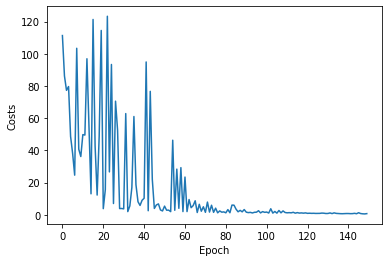

In [349]:
fig = plt.figure()
plt.plot([i for i in range(len(costs))], costs)
plt.xlabel('Epoch')
plt.ylabel('Costs')
plt.show()
#plt.savefig('./qcl-regplot.png')

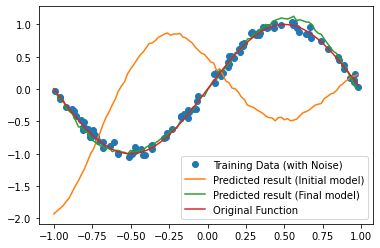

In [350]:
fig = plt.figure()
plt.plot(x_train, y_train, "o", label='Training Data (with Noise)')
plt.plot(x_pred, y_pred_reg_init, label='Predicted result (Initial model)')
plt.plot(x_pred, y_pred_reg_final, label='Predicted result (Final model)')
plt.plot(x_pred, y_pred, label='Original Function')
plt.legend()
plt.show()
#plt.savefig('./qcl-regplot.png')